In [1]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')

import frank_lab


In [2]:
#fileroot = '/Users/ckemere/Development/Data/Frank/Fra';
fileroot = 'SampleData/Fra';



In [3]:
[cellinfo,rawcellinfo] = frank_lab.load_data(fileroot, datatype='cellinfo')
#cellinfo[pd.isnull(cellinfo['area'])]
tetinfo,_ = frank_lab.load_data(fileroot, datatype='tetinfo')



Loading fracellinfo00.mat
Loading fratetinfo.mat


In [4]:
# These are all zero indexed in contrast to their matlab counterparts
Day = 4
Epoch = 5
Tetrode = 9

task = frank_lab.load_data(fileroot, day=Day+1, datatype='task')
task[Day][Epoch].description


Loading fratask05.mat


'TrackA'

In [5]:

# Now, want to generate synthetic data to mimic each tetrode, then detect ripples on them, 
# then generate the ROC plots using m of N rules

eeg = frank_lab.load_data(fileroot, day=Day+1, epoch=Epoch+1, tetrode=Tetrode+1)[Day][Epoch][Tetrode]
#eeg.__dict__ to get fields
data = eeg.data
FS = eeg.samprate
StartTime = eeg.starttime
TimeAxis = StartTime + np.array(range(len(data))) / FS



Loading fraeeg05-6-10.mat


In [6]:
pos = frank_lab.load_data(fileroot, day=Day+1, datatype='pos')


Loading frapos05.mat


In [7]:
len(data)/FS/60

15.266888888888873

In [27]:
# Maggie defines ripples by doing:
#  (1) filter 150-250
#  (2) hilbert envelope
#  (3) smooth with Gaussian (4 ms SD)
#  (4) 3SD above the mean for 15 ms
#  (5) full ripple defined as window back to mean

import ripples
Threshold = 6 # standard deviations above the mean
ripple_events, ripple_maxes, ripple_bounds, ripple_data, ripple_envelope, smoothed_envelope = \
    ripples.detect(data, FS=FS, ThresholdSigma=Threshold)


In [9]:
ripple_maxes.shape

(14,)

In [28]:
# Generate a colored (i.e., filtered white) noise process with same mean and std as ripples
normal_equivalent = np.random.randn(len(ripple_data));
b = signal.firwin(25, [150/(FS/2), 250/(FS/2)], pass_zero=False)
normal_equivalent_ripple = signal.filtfilt(b,1,normal_equivalent);
normal_equivalent_ripple = normal_equivalent_ripple / np.std(normal_equivalent_ripple)
normal_equivalent_ripple = normal_equivalent_ripple * np.std(ripple_data);
ner_envelope = np.absolute(signal.hilbert(normal_equivalent_ripple))
import scipy.ndimage
EnvelopeSmoothingSD = 0.004 * FS
smoothed_ner_envelope = scipy.ndimage.filters.gaussian_filter1d(ner_envelope, EnvelopeSmoothingSD, mode='constant')


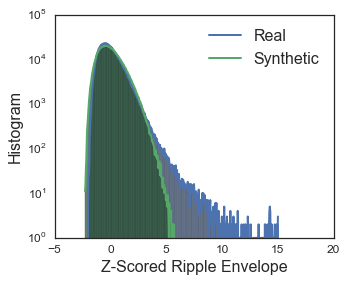

In [19]:
sns.set(rc={'figure.figsize': (5, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('white')


# Compare histogram of envelope of synthetic and real ripples
# Notice that the distribution of the real ripple data has a long tail (corresponding to actual SWR!)
# We plot in terms of z-scores, though the actual numbers are probably also interesting...
z_rip_env = (smoothed_envelope - np.mean(smoothed_envelope))/np.std(smoothed_envelope)
z_ner_env = (smoothed_ner_envelope - np.mean(smoothed_ner_envelope))/np.std(smoothed_ner_envelope)

bins=np.histogram(np.hstack((z_rip_env, z_ner_env)), bins=500)[1]; #get the bin edges
h0, b, p0 = plt.hist(z_rip_env,bins, alpha=0.5);
h1, b, p1 = plt.hist(z_ner_env, bins, alpha=0.5);
plt.plot(bins[0:-1], h0, color=p0[0].get_facecolor(), alpha=1, label='Real')
plt.plot(bins[0:-1], h1, color=p1[0].get_facecolor(), alpha=1, label='Synthetic')
plt.gca().set_yscale('log')
plt.gca().set_xlabel('Z-Scored Ripple Envelope')
plt.gca().set_ylabel('Histogram')
plt.legend()

(0.098238095238095138, 13.080106612081776, 0.45871185747507182, 4.130540612532589)


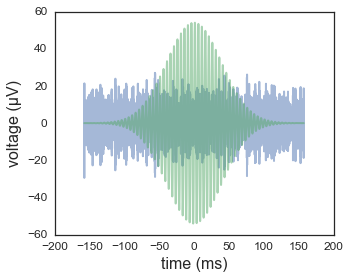

In [34]:
import numpy as np
import scipy.stats
def generate_SWR(PeakLevel, ThresholdFraction=0.6, PeriodAboveThreshold=0.015, FS=30000, FRipple=200, nStdDevs=4, PhaseOffset=0) :
    sigma = PeriodAboveThreshold/2 / np.sqrt(-2 * np.log(ThresholdFraction))
    winSize = round(nStdDevs * sigma * FS)
    t = np.arange(-winSize, winSize+1) / FS
    envelope = scipy.stats.norm.pdf(t, 0, sigma)
    envelope = (envelope/envelope.max()) * PeakLevel
    carrier = np.sin(2*np.pi*FRipple*t + PhaseOffset) * envelope
    return carrier, t, envelope


PeriodAboveThreshold = np.mean(np.diff(ripple_events)) / FS
Peak = np.mean(ripple_maxes)
#ThresholdFraction = 3  * np.std(smoothed_envelope) / Peak
ThresholdFraction = Threshold / (Peak / np.std(smoothed_envelope))
print((PeriodAboveThreshold, Peak/np.std(smoothed_envelope), ThresholdFraction, np.std(smoothed_envelope)))

x,t, _ = generate_SWR(Peak, ThresholdFraction=ThresholdFraction, PeriodAboveThreshold=PeriodAboveThreshold)

plt.plot(1000*t,normal_equivalent_ripple[0:len(t)],alpha=0.5)
plt.plot(1000*t,x,alpha=0.5)
#x2,t, _ = generate_SWR(Peak, ThresholdFraction=ThresholdFraction, PeriodAboveThreshold=PeriodAboveThreshold, PhaseOffset=np.pi)
#plt.plot(t,x2)

FakeRipLen = len(x)
plt.gca().set_ylabel('voltage (µV)')
plt.gca().set_xlabel('time (ms)')

In [ ]:
def evaluate_ripple_detection(ActualEvents, PutativeEvents, LargestLatency, AllowNonCausal=False, MaskLockouts=True):
    if (AllowNonCausal):
        PotentialFalsePositives  = np.array([ActualEvents[k] for k in map(lambda x: (np.abs(ActualEvents - x)).argmin(), PutativeEvents)])
        FalsePositives = np.argwhere(np.abs(PutativeEvents - PotentialFalsePositives) > LargestLatency).squeeze()
        TruePositives = np.argwhere(np.abs(PutativeEvents - PotentialFalsePositives) <= LargestLatency).squeeze()
        
        # Get rid of repeats
        uniques, counts = np.unique(PotentialFalsePositives[TruePositives], return_counts=True)
        Mask = np.ones(TruePositives.shape,dtype=bool)
        for i, u in enumerate(uniques):
            if(counts[i] > 1):
                repeat_idx = np.argwhere(PotentialFalsePositives[TruePositives] == u).squeeze()
                best = np.abs(PotentialFalsePositives[TruePositives[repeat_idx]] - PutativeEvents[TruePositives[repeat_idx]]).argmin()
                repeat_idx = np.delete(repeat_idx, best)
                Mask[repeat_idx] = False          
        FalsePositives = np.append(FalsePositives,TruePositives[~Mask])
        TruePositives = TruePositives[Mask]


        PotentialMisses = np.array([PutativeEvents[k] for k in map(lambda x: (np.abs(PutativeEvents - x)).argmin(), ActualEvents)])
        Misses = np.argwhere(np.abs(ActualEvents - PotentialMisses) > LargestLatency)
    else:
        PotentialFalsePositives  = np.array([ActualEvents[k] for k in map(lambda x: np.where((x - ActualEvents) >= 0, (x - ActualEvents), np.infty).argmin(), PutativeEvents)])
        FalsePositives = np.argwhere((PutativeEvents - PotentialFalsePositives > LargestLatency) | 
                                     (PutativeEvents - PotentialFalsePositives < 0)).squeeze()
        TruePositives = np.argwhere((PutativeEvents - PotentialFalsePositives <= LargestLatency) &
                                    (PutativeEvents - PotentialFalsePositives > 0)).squeeze()
        
        # Get rid of repeats
        uniques, counts = np.unique(PotentialFalsePositives[TruePositives], return_counts=True)
        Mask = np.ones(TruePositives.shape,dtype=bool)
        for i, u in enumerate(uniques):
            if(counts[i] > 1):
                repeat_idx = np.argwhere(PotentialFalsePositives[TruePositives] == u).squeeze()
                best = (PutativeEvents[TruePositives[repeat_idx]] - PotentialFalsePositives[TruePositives[repeat_idx]]).argmin()
                repeat_idx = np.delete(repeat_idx, best)
                Mask[repeat_idx] = False          
        FalsePositives = np.append(FalsePositives,TruePositives[~Mask])
        TruePositives = TruePositives[Mask]
        
        # Potentially look for lockout periods that might have blocked detection (in low threshold cases)
        # Assuming LockoutPeriod and LargestLatency are the same!!!!!
        if (MaskLockouts):
            Mask = np.ones(TruePositives.shape,dtype=bool)
            for idx,k in enumerate(TruePositives):
                if (k > 0):
                    # Flag events where the previous putative event was within a lockout period of the actual event
                    if ((PotentialFalsePositives[k] - PutativeEvents[k - 1]) < LargestLatency) :
                        Mask[idx] = False
            FalsePositives = np.append(FalsePositives,TruePositives[~Mask])
            TruePositives = TruePositives[Mask]

        PotentialMisses = np.array([PutativeEvents[k] for k in map(lambda x: (np.where(PutativeEvents - x >= 0, PutativeEvents - x, np.infty)).argmin(), ActualEvents)])
        Misses = np.argwhere(PotentialMisses - ActualEvents > LargestLatency).squeeze()

    Latencies = PutativeEvents[TruePositives] - PotentialFalsePositives[TruePositives]
    
    return FalsePositives, TruePositives, Latencies, Misses


In [ ]:
# For a given "SNR", the hilbert transform version will have some false positives
# For real-time versions:
#  - compare false positive rate (and misses) to hilbert transform version and ground truth
#  - compare detection latency relative to center, hilbert transform peak, and hilbert transform start
#
# What does realtime look like?
# 1.) filter
# 2.) abs(value)
# 3.) smooth?
# 4.) train on std and mean
# 5.) detect
# 6.) lock out for some period of time and then start again
#
# Implement 1-3 as a function which takes input and returns output

In [ ]:
import numpy as np
def ripple_processor(data, FS=1500, TrainingPeriod=120, ThresholdSigma=4, LockoutPeriod=0.25, Algorithm="unsmooth"):
    def find_events(d, Thresh, TrainBnd, LckPd):
        events = np.argwhere(d > Thresh)
        # get rid of events that happened during training
        events = events[events >= TrainBnd]
        # get rid of events which lie within the Lockout period of previous events
        mask = np.ones(len(events), dtype=bool)
        last = -LckPd -1
        for k, ev in enumerate(events):
            if (ev < last + LckPd):
                mask[k] = False
            else:
                last = ev
        events = events[mask]
        return events

    TrBnd = np.rint(TrainingPeriod*FS).astype(int)
    LckPd = np.rint(LockoutPeriod*FS)
    b, a = scipy.signal.butter(4, [150/(FS/2), 250/(FS/2)], btype='bandpass')
    ripple_band = scipy.signal.lfilter(b, a, data) # causal fitler of signal
    
    if (Algorithm.lower()=="unsmooth"):
        ripple_signal = np.abs(ripple_band)
        mu = np.mean(ripple_signal[:TrBnd])
        sd = np.std(ripple_signal[:TrBnd])
        ripple_events = find_events(ripple_signal, mu + ThresholdSigma*sd, TrBnd, LckPd)
    
    elif (Algorithm.lower()=="smooth"):
        bsmooth, asmooth = scipy.signal.butter(2, 50/(FS/2), btype='lowpass')
        ripple_signal = scipy.signal.lfilter(bsmooth, asmooth, np.abs(ripple_band)) #smooth it
        mu = np.mean(ripple_signal[:TrBnd])
        sd = np.std(ripple_signal[:TrBnd])
        ripple_events = find_events(ripple_signal, mu + ThresholdSigma*sd, TrBnd, LckPd)
        
    elif (Algorithm.lower()=="hbt"):
        g = np.zeros(20)
        gptr = 0
        last_stim = 0
        def updateGain(d, g, gptr):
            mn = g.mean()
            g[gptr] = d
            gptr = gptr + 1 if (gptr < 19) else 0
            return mn, g, gptr
        
        mu = 0
        sd = 0
        ripple_events = []
        v = np.zeros(ripple_band.shape)
        # Algorithm from Jadhav et al Science 2012
        for k, x in enumerate(ripple_band):
            if (k > 0):
                df = x - v[k-1]
            else:
                df = x

            if (df > 0):
                gain, g, gptr = updateGain(1.2, g, gptr)
                v[k] = v[k-1] + gain * df
            else:
                _, g, gptr = updateGain(2.0, g, gptr)
                v[k] = v[k-1] + 2.0 * df
                
            mu = mu + (x - mu) / 10000
            sd = (np.abs(x - mu) - sd) / 10000 + sd
            if ((k > TrBnd) & ((k-last_stim) > LckPd)) :
                if (v[k] > mu + ThresholdSigma*sd) :
                    ripple_events.append(k)
                    last_stim = k
        ripple_events = np.array(ripple_events)
        ripple_signal = v
    else:
        raise ValueError("Unknown algorithm specified")
    
    return ripple_events, ripple_signal, mu, sd, ripple_band

In [ ]:

Threshold = 3.5 # standard deviations above the mean
ripple_events, ripple_maxes, ripple_bounds, ripple_data, ripple_envelope, smoothed_envelope = \
    ripples.detect(data, FS=FS, ThresholdSigma=Threshold)

PeriodAboveThreshold = np.mean(np.diff(ripple_events)) / FS
Peak = np.mean(ripple_maxes)
ThresholdFraction = Threshold / (Peak / np.std(smoothed_envelope))
print((len(ripple_maxes), PeriodAboveThreshold, Peak, ThresholdFraction))
   
NRipsToAdd = 150 # len(ripple_maxes)
PhaseOffsets = np.random.rand(NRipsToAdd)*2*np.pi
EdgeExclude = FS*10
RippleInsertionIdx = np.rint(np.linspace(EdgeExclude, len(normal_equivalent_ripple) - EdgeExclude, NRipsToAdd))

added_ripples = normal_equivalent_ripple.copy()
for k in range(NRipsToAdd):
    x,t, _ = generate_SWR(Peak, ThresholdFraction=ThresholdFraction, 
                          PeriodAboveThreshold=PeriodAboveThreshold,
                          PhaseOffset=PhaseOffsets[k])
    added_ripples[(np.rint(t * FS) + RippleInsertionIdx[k]).astype(int)] += x
    

fake_ripple_bounds, fake_ripple_maxes, fake_ripple_events, fake_ripple_data, fake_ripple_envelope, fake_smoothed_envelope = \
    ripples.detect(added_ripples, FS=FS, ThresholdSigma=Threshold)

print('Number of ripples injected: {:4d}. Number detected: {:4d}.'.format(NRipsToAdd, len(fake_ripple_maxes)))

# Compare histogram of envelope of synthetic and real ripples
# Notice that the distribution of the real ripple data has a long tail (corresponding to actual SWR!)

#bins=np.histogram(np.hstack((smoothed_envelope,fake_smoothed_envelope)), bins=500)[1]; #get the bin edges
#plt.hist(smoothed_envelope,bins);
#plt.hist(fake_smoothed_envelope, bins);
#plt.gca().set_yscale('log')



In [ ]:


LargestLatency = 0.25 * FS
FalsePositives, TruePositives, Latencies, Misses = evaluate_ripple_detection(RippleInsertionIdx, 
                                        fake_ripple_bounds[:,0], 
                                        LargestLatency,
                                        AllowNonCausal=True)
TrainingPeriod = 120

NonTrainingRipTimes = fake_ripple_bounds[TruePositives,0]
NonTrainingRipTimes = NonTrainingRipTimes[NonTrainingRipTimes > TrainingPeriod*FS]



In [ ]:
t = np.array(range(len(added_ripples)))/FS
plt.plot(t, added_ripples)
plt.plot(t, fake_ripple_envelope)
print("Mean fake rippe envelope = {}".format(np.mean(fake_ripple_envelope)))
#plt.stem(rip_evs, (m+5*s)*np.ones(len(rip_evs)))
rip_bnds = np.zeros(len(added_ripples))
for bnd in fake_ripple_bounds:
    rip_bnds[bnd[0]:bnd[1]] = 1;
plt.plot(t, rip_bnds*3*np.std(fake_ripple_envelope))
rip_bnds2 = np.zeros(len(added_ripples))
for bnd in fake_ripple_events:
    rip_bnds2[bnd[0]:bnd[1]] = 1;
plt.plot(t, rip_bnds2*40)


#plt.stem(RippleInsertionIdx, 20*np.ones(len(RippleInsertionIdx)),'y')

rip_evs,ripple_signal,m,s,filt_rip = ripple_processor(added_ripples, ThresholdSigma=3.5, TrainingPeriod=TrainingPeriod)
fps, tps, latencies, _  = evaluate_ripple_detection(NonTrainingRipTimes, rip_evs, LargestLatency)
plt.stem(rip_evs[tps]/FS, 20*np.ones(len(tps)),'g',linewidth=2)

plt.gca().set_xlim([fake_ripple_bounds[21,1]/FS-0.25,fake_ripple_bounds[21,1]/FS+0.25])

plt.show()

In [ ]:
for j in fake_ripple_bounds:
    print(j)
    break

In [ ]:
#import scipy.io.wavfile
#from scipy import interpolate

# (Threshold = 6)
#t = np.linspace(0,501,FS*501,endpoint=False)
#f = interpolate.interp1d(t,added_ripples[:FS*501])
#t2  = np.linspace(0,500,8000*500,endpoint=False)
#upsamprips = f(t2)

#scipy.io.wavfile.write("test.wav",8000,(upsamprips*100).astype(np.int16))

In [ ]:

ThresholdSigmas = np.arange(1,9,0.25)
FalsePositives = np.zeros((len(ThresholdSigmas),3))
DetectedRipples = np.zeros((len(ThresholdSigmas),3))
MeanLatencies = np.zeros((len(ThresholdSigmas),3))
StdLatencies = np.zeros((len(ThresholdSigmas),3))
for i,ts in enumerate(ThresholdSigmas):
    print(ts)
    rip_evs,ripple_signal,m,s,filt_rip = ripple_processor(added_ripples, ThresholdSigma=ts, TrainingPeriod=TrainingPeriod)
    fps, tps, latencies, _  = evaluate_ripple_detection(NonTrainingRipTimes, rip_evs, LargestLatency)
    FalsePositives[i,0] = len(fps)
    DetectedRipples[i,0] = len(tps)
    MeanLatencies[i,0] = np.mean(latencies)
    StdLatencies[i,0] = np.std(latencies)

    rip_evs,ripple_signal,m,s,filt_rip = ripple_processor(added_ripples, ThresholdSigma=ts, 
                                                          TrainingPeriod=TrainingPeriod, Algorithm="smooth")
    fps, tps, latencies, _  = evaluate_ripple_detection(NonTrainingRipTimes, rip_evs, LargestLatency)
    FalsePositives[i,1] = len(fps)
    DetectedRipples[i,1] = len(tps)
    MeanLatencies[i,1] = np.mean(latencies)
    StdLatencies[i,1] = np.std(latencies)

    rip_evs,ripple_signal,m,s,filt_rip = ripple_processor(added_ripples, ThresholdSigma=ts, 
                                                          TrainingPeriod=TrainingPeriod, Algorithm="hbt")
    fps, tps, latencies, _  = evaluate_ripple_detection(NonTrainingRipTimes, rip_evs, LargestLatency)
    FalsePositives[i,2] = len(fps)
    DetectedRipples[i,2] = len(tps)
    MeanLatencies[i,2] = np.mean(latencies)
    StdLatencies[i,2] = np.std(latencies)
   



In [ ]:

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

miss_rate = plt.plot(MeanLatencies/FS, 1-DetectedRipples/len(NonTrainingRipTimes))
false_pos = plt.plot(MeanLatencies/FS, FalsePositives/len(NonTrainingRipTimes))
plt.legend(miss_rate+false_pos, ['$Miss_{abs}$', '$Miss_{smooth}$', 
                                 '$Miss_{hbt}$','$FP_{abs}$', '$FP_{smooth}$', '$FP_{hbt}$'])
plt.plot(np.mean(fake_ripple_events[RippleInsertionIdx > TrainingPeriod*FS,0]- NonTrainingRipTimes)*np.ones(2)/FS,[0,1],':')
plt.gca().set_ylim([0,0.1])
plt.gca().set_xlim([20/FS,140/FS])
plt.show()


In [ ]:
plt.plot(ThresholdSigmas, 1-DetectedRipples/len(NonTrainingRipTimes))
plt.gca().set_ylim([0,0.1])